In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from datetime import datetime, timedelta

# Generate Mock Data

# Set mean Poisson values for each team
theta = {
    'England': 3,     # England
    'France': 3.5,   # France
    'Ireland': 4,   # Ireland
    'Italy': 1.5,   # Italy
    'Scotland': 2,   # Scotland
    'Wales': 0.5    # Wales
}

# Gamma shape parameter
alpha = 3

def get_nb_vals(mu, alpha, size=1):
    """Generate negative binomially distributed samples."""
    g = stats.gamma.rvs(alpha, scale=mu / alpha, size=size)
    return stats.poisson.rvs(g)


teams = np.array(['England','France','Ireland','Italy','Scotland','Wales'])

# Generate home & away fixtures for all team pairs
matchups = []
for home_team in teams:
    for away_team in teams:
        if home_team != away_team:  # Avoid self-matchups
            matchups.append([home_team, away_team])  # Home game
            matchups.append([away_team, home_team])  # Reverse fixture (away)

# Convert matchups to DataFrame
match_data = pd.DataFrame(matchups, columns=["home_team", "away_team"])

# Generate team_tries and opp_tries for each row
match_data["home_tries"] = [get_nb_vals(theta[team], alpha) for team in match_data["home_team"]]
match_data["away_tries"] = [get_nb_vals(theta[opp], alpha) for opp in match_data["away_team"]]

# Generate match dates starting from January 1, 2024
start_date = datetime(2024, 1, 1)
match_data["match_date"] = [start_date + timedelta(days=i) for i in range(len(match_data))]

# Convert match_date to string format (optional)
match_data["match_date"] = match_data["match_date"].dt.strftime("%Y-%m-%d")

# Create game num column
match_data['game_num'] = match_data.index + 1


In [3]:
# Now, create a restructured DataFrame where each match appears twice
df_expanded = pd.concat([
    match_data.rename(columns={
        "home_team": "team", 
        "away_team": "opp", 
        "home_tries": "team_tries", 
        "away_tries": "opp_tries"
    }).assign(home_indicator=1),
        match_data.rename(columns={
        "away_team": "team", 
        "home_team": "opp", 
        "away_tries": "team_tries", 
        "home_tries": "opp_tries"
    }).assign(home_indicator=0),
], ignore_index=True)

# Sort by match date for readability
df_expanded = df_expanded.sort_values(by="match_date").reset_index(drop=True)

# Create mappings
# Identify teams to remove based on counts

import numpy as np

teams_unq = df_expanded['team'].unique()
opp_unq = df_expanded['opp'].unique()

# Concatenate the arrays and keep unique values
unique_teams = np.unique(np.concatenate((teams_unq, opp_unq)))

# Sort the unique_teams list alphabetically
unique_teams_sorted = sorted(unique_teams)

# get number of teams
n_teams = len(unique_teams_sorted)
print(n_teams)

# Create the mapping (team name to index starting from 0)
team_mapping = {team: index for index, team in enumerate(unique_teams_sorted)}

# Print the mapping
print(team_mapping)

# Map the teams to numbers
df_expanded['team_num'] = df_expanded['team'].map(team_mapping)
df_expanded['opp_num'] = df_expanded['opp'].map(team_mapping)



6
{'England': 0, 'France': 1, 'Ireland': 2, 'Italy': 3, 'Scotland': 4, 'Wales': 5}


In [4]:
# Group by team and calculate mean and variance
team_avg = df_expanded.groupby('team').agg(
    team_tries_mean=('team_tries', 'mean'),
    team_tries_var=('team_tries', 'var'),
    opponent_tries_mean=('opp_tries', 'mean'),
    opponent_tries_var=('opp_tries', 'var')
).reset_index().round(2)

# Display the result
team_avg


,team,team_tries_mean,team_tries_var,opponent_tries_mean,opponent_tries_var
0,England,2.20,3.01,2.2,7.01
1,France,3.30,9.38,2.0,3.58
2,Ireland,4.45,12.16,2.3,6.96
3,Italy,1.25,0.83,3.0,12.21
4,Scotland,1.20,1.22,1.6,2.15
5,Wales,0.80,0.69,2.1,4.94


In [5]:
# Now try create the model

# Use Negative Binomial Model
import pymc as pm

# Create Model
with pm.Model() as nb_model:

    # Think this is the only shared data I need
    team_shared = pm.MutableData("team_shared", df_expanded['team_num'].values)
    opp_shared = pm.MutableData("opp_shared", df_expanded['opp_num'].values)
    team_home_ind_shared = pm.MutableData("team_home_ind_shared",
                                          df_expanded['home_indicator'].values)

    # Param for Home to be used for tries
    #home_param_tries = pm.Normal("home_param_tries", 0, 1)
    
    # Data used for Likelihoods in Model - all observed
    team_tries = df_expanded['team_tries'].values


    # Attack ratings for teams - common mu and sd that all teams draw from
    atts_mu = pm.Normal("atts_mu", 0, 1)
    atts_sd = pm.HalfNormal("atts_sd", 1)
    atts = pm.Normal("atts", mu=atts_mu, sigma=atts_sd, shape=n_teams)

    # Have 1 common defence parameter
    #defs_mu = pm.Normal("defs_mu", 0, 1)
    #defs_sd = pm.HalfNormal("defs_sd", 1)
    #defs = pm.Normal("defs", mu=defs_mu, sigma=defs_sd, shape=n_teams)

    # coefficient for team interaction
    #team_interaction = pm.Normal("team_interaction", mu=0, sigma=1, shape=(n_teams, n_teams) )

    # Calculate theta for tries and pg dg
    # Added an interaction term to show how teams match up
    # + team_interaction[team_shared, opp_shared]
    # home_param_tries*team_home_ind_shared
    # + defs[opp_shared]
    tries_theta = pm.Deterministic("tries_theta", pm.math.exp( 
                                                        atts[team_shared]
                                                             ) )

    # Create alpha - Gamma shape parameter
    alpha_tries = pm.HalfNormal("alpha_tries",2)

    # Negative Binomial for tries
    # Tries theta slightly larger than atts due to alpha parameter
    # Also exponential transform is non linear - jensens inequality
    tries_nb = pm.NegativeBinomial("tries_nb",
                                   mu=tries_theta, 
                                      alpha=alpha_tries, 
                                        observed=team_tries,
                                        shape = tries_theta.shape)


    # Get prior samples
    #prior_samples = pm.sample_prior_predictive(100)

# Create Model
with nb_model:
    trace_pool = pm.sample(1000, tune=2000, cores=4, return_inferencedata=True)


# Define score model
with nb_model:
    score_model = pm.Deterministic("score_model", tries_nb * 5)
    
    # Sample from posterior predictive
    posterior_predictive_samples_pool = pm.sample_posterior_predictive(trace_pool, extend_inferencedata=True)




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [atts_mu, atts_sd, atts, alpha_tries]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 40 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [tries_nb]


In [6]:
# Show Summary

import arviz as az

# Generate the summary of the posterior
summary_df = az.summary(trace_pool.posterior, round_to=2)

#print(summary_df.columns)

# filter for columns
summary_df = summary_df[['mean','sd','hdi_3%','hdi_97%','r_hat']]

# Add in teams
def replace_index_with_team_name(index, mapping):
    # Match patterns like "atts[0]" or "defs[0,0]" and replace indices with team names
    if (index.startswith("atts[") 
        or index.startswith("defs[") 
        or index.startswith("team_interaction[") 
       ):
        # Extract the parameter type (e.g., "atts" or "defs") and the team indices
        param_type = index.split("[")[0]
        team_indices = index.split("[")[1].strip("]").split(",")  # Extract numbers inside brackets
        
        # Replace each team index with its corresponding name
        team_names = []
        for team_index in team_indices:
            team_index = int(team_index)  # Convert to int
            for team, num in mapping.items():
                if num == team_index:
                    team_names.append(team)
                    break  # Stop searching once found
            else:
                team_names.append(str(team_index))  # Keep original number if no match
        
        # Reconstruct the updated parameter string
        return f"{param_type}[{','.join(team_names)}]"
    
    return index  # Leave other rows unchanged


summary_df = summary_df.rename(index=lambda x: replace_index_with_team_name(x, team_mapping))


# Set display options
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns


# Create exponential of column
# Not sure why r hat is so large too
summary_df['mean_exp'] = round(np.exp(summary_df['mean']),2)


In [7]:


# Show df for pooled model
summary_df[summary_df.index.str.contains('atts')]

,mean,sd,hdi_3%,hdi_97%,r_hat,mean_exp
atts_mu,0.56,0.31,-0.04,1.17,1.0,1.75
atts[England],0.77,0.19,0.41,1.13,1.0,2.16
atts[France],1.15,0.18,0.81,1.49,1.0,3.16
atts[Ireland],1.43,0.17,1.11,1.75,1.0,4.18
atts[Italy],0.26,0.23,-0.20,0.68,1.0,1.30
atts[Scotland],0.22,0.23,-0.22,0.65,1.0,1.25
atts[Wales],-0.10,0.26,-0.58,0.38,1.0,0.90
atts_sd,0.75,0.28,0.32,1.25,1.0,2.12


In [8]:
summary_df[summary_df.index.str.contains('alpha_tries')]

,mean,sd,hdi_3%,hdi_97%,r_hat,mean_exp
alpha_tries,2.88,0.77,1.57,4.34,1.0,17.81


In [9]:
# Now try create the model

# Use Negative Binomial Model
import pymc as pm

# Create Model
with pm.Model() as no_pool_model:

    # Think this is the only shared data I need
    team_shared = pm.MutableData("team_shared", df_expanded['team_num'].values)
    opp_shared = pm.MutableData("opp_shared", df_expanded['opp_num'].values)
    team_home_ind_shared = pm.MutableData("team_home_ind_shared", df_expanded['home_indicator'].values)

    
    # Data used for Likelihoods in Model - all observed
    team_tries = df_expanded['team_tries'].values



    # Changed this to half normal to have positive values
    # Problem was using half normal here
    atts = pm.Normal("atts", sigma=1, shape=n_teams)


    tries_theta = pm.Deterministic("tries_theta", pm.math.exp( 
                                                        atts[team_shared]
                                                            ) )

    # Create alpha - Gamma shape parameter
    alpha_tries = pm.HalfNormal("alpha_tries",2)

    # Negative Binomial for tries
    tries_nb = pm.NegativeBinomial("tries_nb",
                                   mu=tries_theta, 
                                      alpha=alpha_tries, 
                                        observed=team_tries,
                                        shape = tries_theta.shape)


    # Get prior samples
    #prior_samples = pm.sample_prior_predictive(100)

# Create Model
with no_pool_model:
    trace_no_pool = pm.sample(1000, tune=2000, cores=4, return_inferencedata=True)


# Define score model
with no_pool_model:
    score_model = pm.Deterministic("score_model", tries_nb * 5)
    
    # Sample from posterior predictive
    posterior_predictive_samples_np = pm.sample_posterior_predictive(trace_no_pool, extend_inferencedata=True)




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [atts, alpha_tries]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 37 seconds.
Sampling: [tries_nb]


In [10]:
import arviz as az

# Generate the summary of the posterior
summary_df_np = az.summary(trace_no_pool.posterior, round_to=2)


# filter for columns
summary_df_np = summary_df_np[['mean','sd','hdi_3%','hdi_97%','r_hat']]

# Add in teams
summary_df_np = summary_df_np.rename(index=lambda x: replace_index_with_team_name(x, team_mapping))

# Show df for Non Pooling Model
# THese estimates seem worse
# Maybe need to plot the distribution to see the difference
summary_df_np['mean_exp'] = round(np.exp(summary_df_np['mean']),2)



In [11]:
# Show no pooling estimates
# Wales estimate is good bit off - this was because of half normal distribution
# This resticted it to be positive making worse estimates - even though r hat was still ok
# Need a new metric to determine accuracy
# Maybe plot Actual vs Sim - try half normal again
summary_df_np[summary_df_np.index.str.contains('atts')]

,mean,sd,hdi_3%,hdi_97%,r_hat,mean_exp
atts[England],0.76,0.20,0.39,1.13,1.0,2.14
atts[France],1.16,0.18,0.82,1.49,1.0,3.19
atts[Ireland],1.46,0.17,1.16,1.77,1.0,4.31
atts[Italy],0.20,0.24,-0.23,0.65,1.0,1.22
atts[Scotland],0.16,0.24,-0.28,0.62,1.0,1.17
atts[Wales],-0.23,0.28,-0.77,0.27,1.0,0.79


In [12]:
# Some Shrinkage here
summary_df[summary_df.index.str.contains('atts')]

,mean,sd,hdi_3%,hdi_97%,r_hat,mean_exp
atts_mu,0.56,0.31,-0.04,1.17,1.0,1.75
atts[England],0.77,0.19,0.41,1.13,1.0,2.16
atts[France],1.15,0.18,0.81,1.49,1.0,3.16
atts[Ireland],1.43,0.17,1.11,1.75,1.0,4.18
atts[Italy],0.26,0.23,-0.20,0.68,1.0,1.30
atts[Scotland],0.22,0.23,-0.22,0.65,1.0,1.25
atts[Wales],-0.10,0.26,-0.58,0.38,1.0,0.90
atts_sd,0.75,0.28,0.32,1.25,1.0,2.12


In [15]:
# Display the result
# A negative Binomial Model is skewed
team_avg

,team,team_tries_mean,team_tries_var,opponent_tries_mean,opponent_tries_var
0,England,2.20,3.01,2.2,7.01
1,France,3.30,9.38,2.0,3.58
2,Ireland,4.45,12.16,2.3,6.96
3,Italy,1.25,0.83,3.0,12.21
4,Scotland,1.20,1.22,1.6,2.15
5,Wales,0.80,0.69,2.1,4.94


In [13]:
summary_df_np[summary_df_np.index.str.contains('alpha_tries')]

,mean,sd,hdi_3%,hdi_97%,r_hat,mean_exp
alpha_tries,2.91,0.77,1.66,4.43,1.0,18.36


In [14]:
summary_df[summary_df.index.str.contains('alpha_tries')]

,mean,sd,hdi_3%,hdi_97%,r_hat,mean_exp
alpha_tries,2.88,0.77,1.57,4.34,1.0,17.81


In [68]:
summary_df[summary_df.index.str.contains('tries')].head(5)

,mean,sd,hdi_3%,hdi_97%,r_hat,mean_exp
alpha_tries,2.39,0.59,1.37,3.46,1.0,10.91
tries_theta[0],3.48,0.67,2.31,4.75,1.0,32.46
tries_theta[1],3.89,0.71,2.64,5.25,1.0,48.91
tries_theta[2],3.89,0.71,2.64,5.25,1.0,48.91
tries_theta[3],3.48,0.67,2.31,4.75,1.0,32.46


In [22]:
summary_df

,mean,sd,hdi_3%,hdi_97%,r_hat,mean_exp
atts_mu,0.56,0.31,-0.04,1.17,1.0,1.75
atts[England],0.77,0.19,0.41,1.13,1.0,2.16
atts[France],1.15,0.18,0.81,1.49,1.0,3.16
atts[Ireland],1.43,0.17,1.11,1.75,1.0,4.18
atts[Italy],0.26,0.23,-0.20,0.68,1.0,1.30
atts[Scotland],0.22,0.23,-0.22,0.65,1.0,1.25
atts[Wales],-0.10,0.26,-0.58,0.38,1.0,0.90
atts_sd,0.75,0.28,0.32,1.25,1.0,2.12
alpha_tries,2.88,0.77,1.57,4.34,1.0,17.81
tries_theta[0],2.20,0.43,1.46,3.02,1.0,9.03


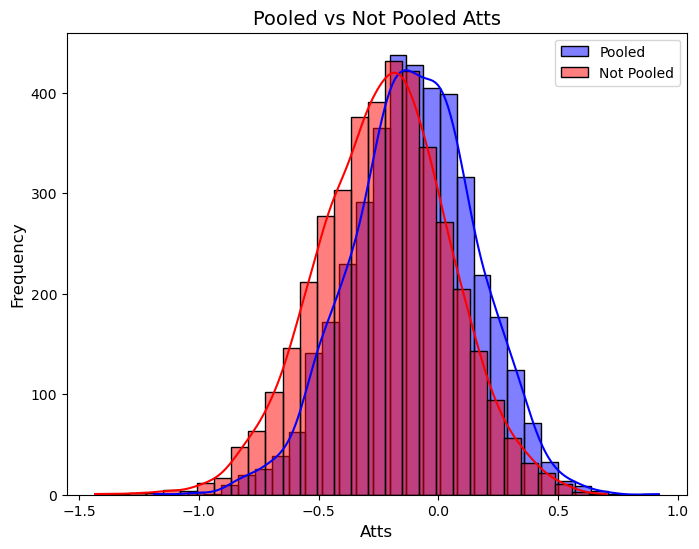

In [16]:
# Now plot Pooled vs Not Pooled
# Pooled Distribution shifted slightly right

import matplotlib.pyplot as plt
import seaborn as sns

atts_no_pool = trace_no_pool.posterior.atts.stack(sample=("chain", "draw"))
atts_pool = trace_pool.posterior.atts.stack(sample=("chain", "draw"))

set_team = 5

# create arrays for team
team_no_pool = atts_no_pool[set_team].values
team_pool = atts_pool[set_team].values

# Create the plot
plt.figure(figsize=(8, 6))

# Plot Pooled atts
sns.histplot(team_pool, bins=30, kde=True, color='blue', label="Pooled", alpha=0.5)

# Plot Not pooled atts
sns.histplot(team_no_pool, bins=30, kde=True, color='red', label="Not Pooled", alpha=0.5)

# Add labels and title
plt.xlabel("Atts", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Pooled vs Not Pooled Atts", fontsize=14)

# Add legend
plt.legend()

# Show the plot
plt.show()


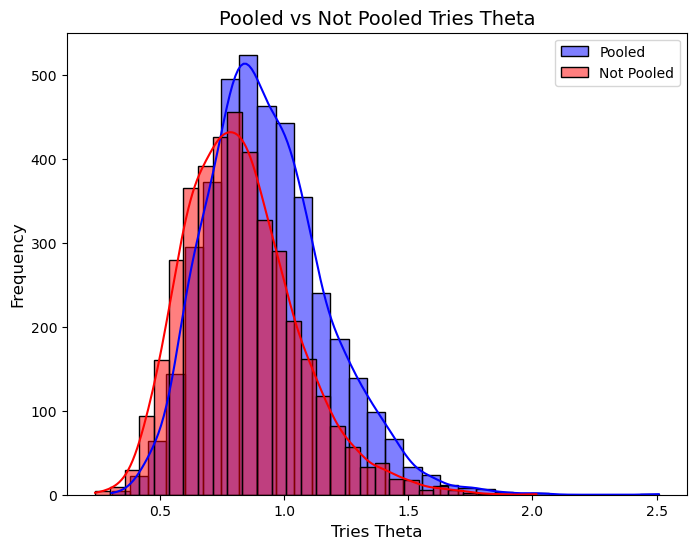

In [20]:
# Plot tries theta Pooled vs not pooled

import matplotlib.pyplot as plt
import seaborn as sns

tries_theta_no_pool = trace_no_pool.posterior.tries_theta.stack(sample=("chain", "draw"))
tries_theta_pool = trace_pool.posterior.tries_theta.stack(sample=("chain", "draw"))

# this obs is Wales
set_obs = 59

# create arrays for team
obs_no_pool = tries_theta_no_pool[set_obs].values
obs_pool = tries_theta_pool[set_obs].values

# Create the plot
plt.figure(figsize=(8, 6))

# Plot Pooled atts
sns.histplot(obs_pool, bins=30, kde=True, color='blue', label="Pooled", alpha=0.5)

# Plot Not pooled atts
sns.histplot(obs_no_pool, bins=30, kde=True, color='red', label="Not Pooled", alpha=0.5)

# Add labels and title
plt.xlabel("Tries Theta", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Pooled vs Not Pooled Tries Theta", fontsize=14)

# Add legend
plt.legend()

# Show the plot
plt.show()


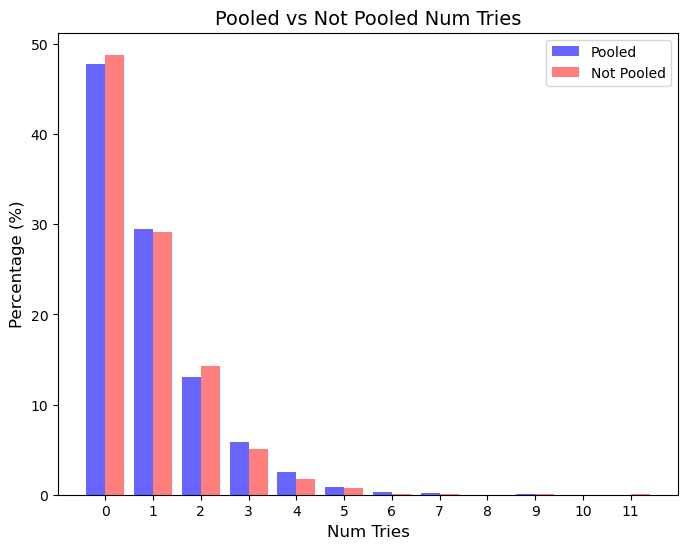

In [21]:
# Plot predicted number of Tries from Model

import matplotlib.pyplot as plt
import seaborn as sns

num_tries_no_pool = trace_no_pool.posterior_predictive.tries_nb.stack(sample=("chain", "draw"))
num_tries_pool = trace_pool.posterior_predictive.tries_nb.stack(sample=("chain", "draw"))

set_obs = 59

# create arrays for team
obs_no_pool = num_tries_no_pool[set_obs].values
obs_pool = num_tries_pool[set_obs].values

# Count occurrences of each value
values_no_pool, counts_no_pool = np.unique(obs_no_pool, return_counts=True)
values_pool, counts_pool = np.unique(obs_pool, return_counts=True)

# Convert to percentage
counts_no_pool = (counts_no_pool / counts_no_pool.sum()) * 100
counts_pool = (counts_pool / counts_pool.sum()) * 100

# Define bar width
bar_width = 0.4

# Create the plot
plt.figure(figsize=(8, 6))

# Plot bars for pooled model (shifted left slightly)
plt.bar(values_pool - bar_width/2, counts_pool, width=bar_width, color="blue", alpha=0.6, label="Pooled")

# Plot bars for no-pool model (shifted right slightly)
plt.bar(values_no_pool + bar_width/2, counts_no_pool, width=bar_width, color="red", alpha=0.5, label="Not Pooled")

# Set x-axis ticks for better visualization
plt.xticks(np.arange(min(values_no_pool.min(), values_pool.min()), 
                     max(values_no_pool.max(), values_pool.max()) + 1, 1))  # Add more x-ticks


# Add labels and title
plt.xlabel("Num Tries", fontsize=12)

# Convert y-axis to percentage format
plt.ylabel("Percentage (%)", fontsize=12)

plt.title("Pooled vs Not Pooled Num Tries", fontsize=14)

# Add legend
plt.legend()

# Show the plot
plt.show()


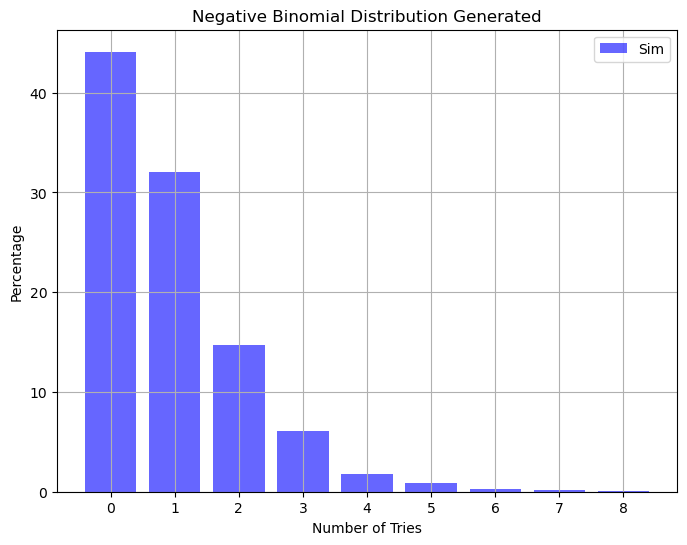

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom
from scipy.stats import nbinom, skew

# Compare values to generated distribution

# Define mean and dispersion parameters
mu = 0.93  # Mean number of tries per game
alpha = 2.88  # Dispersion parameter (higher = more variance)


def get_nb_vals(mu, alpha, size):
    """Generate negative binomially distributed samples by
    drawing a sample from a gamma distribution with mean `mu` and
    shape parameter `alpha', then drawing from a Poisson
    distribution whose rate parameter is given by the sampled
    gamma variable.

    """

    g = stats.gamma.rvs(alpha, scale=mu / alpha, size=size)
    return stats.poisson.rvs(g)

gen_nb_values = get_nb_vals(mu, alpha, 4000)

# Count occurrences of each value
values, counts = np.unique(gen_nb_values, return_counts=True)

# Convert to percentage
counts = (counts / counts.sum()) * 100

# Define bar width
bar_width = 0.8

# Create the plot
plt.figure(figsize=(8, 6))

# Plot bars for pooled model (shifted left slightly)
plt.bar(values, counts, width=bar_width, color="blue", alpha=0.6, label="Sim")
plt.xlabel("Number of Tries")
plt.ylabel("Percentage")
plt.title("Negative Binomial Distribution Generated")
# Set x-axis ticks for better visualization
plt.xticks(np.arange(min(values), 
                     max(values) + 1, 1))  # Add more x-ticks
plt.legend()
plt.grid()
plt.show()



In [24]:
# Now how do I measure the performance
# Think the wrong metric looked at here

observed_mean = df_expanded["team_tries"].mean()
observed_variance = df_expanded["team_tries"].var()

# Have to look at variance of tries not tries theta - which is mean expected
predicted_mean = trace_pool.posterior_predictive["tries_nb"].mean().item()
predicted_variance = trace_pool.posterior_predictive["tries_nb"].var().item()

print(f"Observed Mean: {observed_mean:.2f}, Predicted Mean: {predicted_mean:.2f}")
print(f"Observed Variance: {observed_variance:.2f}, Predicted Variance: {predicted_variance:.2f}")


Observed Mean: 2.20, Predicted Mean: 2.21
Observed Variance: 6.06, Predicted Variance: 6.24


C:\Users\killi\anaconda3\envs\pymc5\Lib\site-packages\arviz\plots\ppcplot.py:268: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
C:\Users\killi\anaconda3\envs\pymc5\Lib\site-packages\arviz\plots\ppcplot.py:272: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


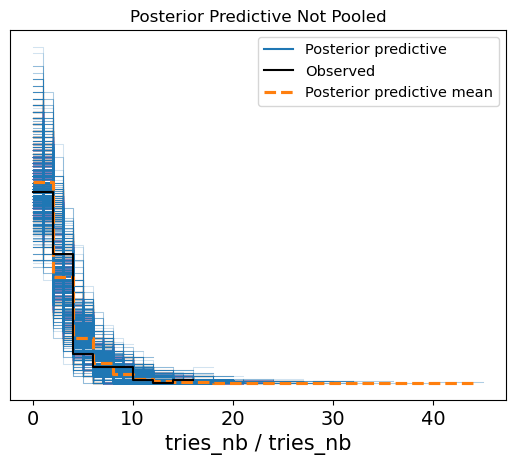

In [25]:
import arviz as az

# Posterior Predictive Check
az.plot_ppc(posterior_predictive_samples_np, var_names=["tries_nb"])
plt.title("Posterior Predictive Not Pooled")
plt.show()

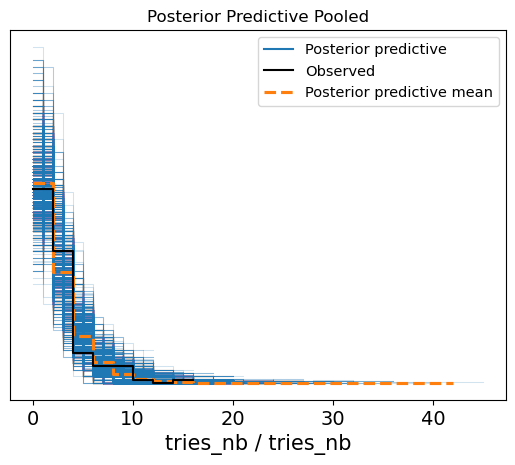

In [26]:
import arviz as az

# Posterior Predictive Check
az.plot_ppc(posterior_predictive_samples_pool, var_names=["tries_nb"])
plt.title("Posterior Predictive Pooled")
plt.show()

In [98]:
waic = az.waic(trace_no_pool)
loo = az.loo(trace_pool)

print(f"WAIC: {waic.waic:.2f}, LOO: {loo.loo:.2f}")

TypeError: log likelihood not found in inference data object

mean sim:  2.27
median sim:  2.0


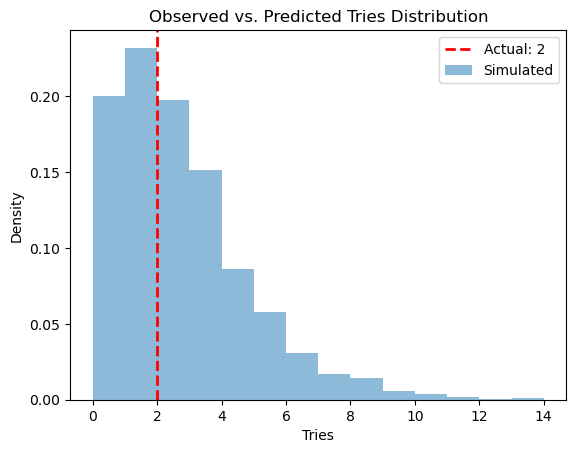

In [27]:
# Compare observed vs predicted
# Probably want to plot just a single data point to find outliers

set_obs = 0
actual_data = df_expanded["team_tries"].iloc[set_obs]
sim_data = posterior_predictive_samples_pool.posterior_predictive["tries_nb"].stack(sample=("chain", "draw"))[set_obs].values

plt.axvline(actual_data, color='red', linestyle='--', linewidth=2, label=f'Actual: {actual_data}')
plt.hist(sim_data, bins=range(15), alpha=0.5, label="Simulated", density=True)

print('mean sim: ',np.round(np.mean(sim_data),2))
print('median sim: ',np.median(sim_data))

plt.xlabel("Tries")
plt.ylabel("Density")
plt.legend()
plt.title("Observed vs. Predicted Tries Distribution")
plt.show()

C:\Users\killi\anaconda3\envs\pymc5\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


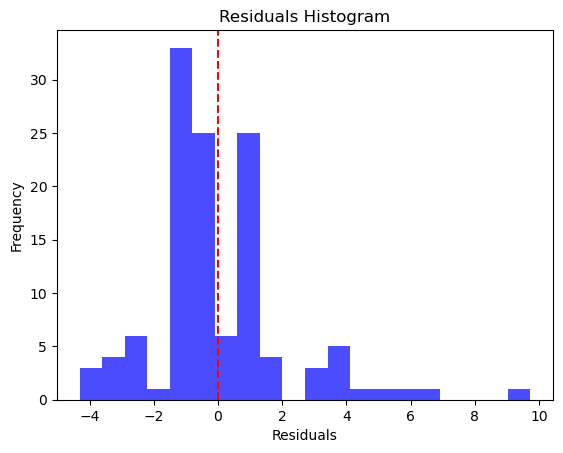

In [28]:

# Residual Analysis
# Don't think tries theta should be used here, but tries nb
# Be interesting to see the difference - values are similar
# Mean should be used and not Median - MLE optimises the mean - minimises the log function
# Instead of MLE and optimising for single value, pymc estimates posterior
# 
df_expanded["mean_tries_theta"] = np.round(posterior_predictive_samples_pool.posterior["tries_theta"].mean(dim=("chain", "draw")),2)
df_expanded["predicted_tries_mean"] = np.round(posterior_predictive_samples_pool.posterior_predictive["tries_nb"].mean(dim=("chain", "draw")),2)
df_expanded["predicted_tries_median"] = posterior_predictive_samples_pool.posterior_predictive["tries_nb"].median(dim=("chain", "draw"))

df_expanded["raw_residuals"] = df_expanded["team_tries"] - df_expanded["predicted_tries_mean"]

df_expanded["pearson_residuals"] = df_expanded["raw_residuals"] / np.sqrt(df_expanded["predicted_tries_mean"] )
df_expanded["deviance_residuals"] = np.sign(df_expanded["raw_residuals"]) * np.sqrt(
    2 * (df_expanded["team_tries"] * np.log(df_expanded["team_tries"] / df_expanded["predicted_tries_mean"]) - df_expanded["raw_residuals"])
)

plt.hist(df_expanded["raw_residuals"], bins=20, alpha=0.7, color="blue")
plt.axvline(0, color="red", linestyle="dashed")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Histogram")
plt.show()

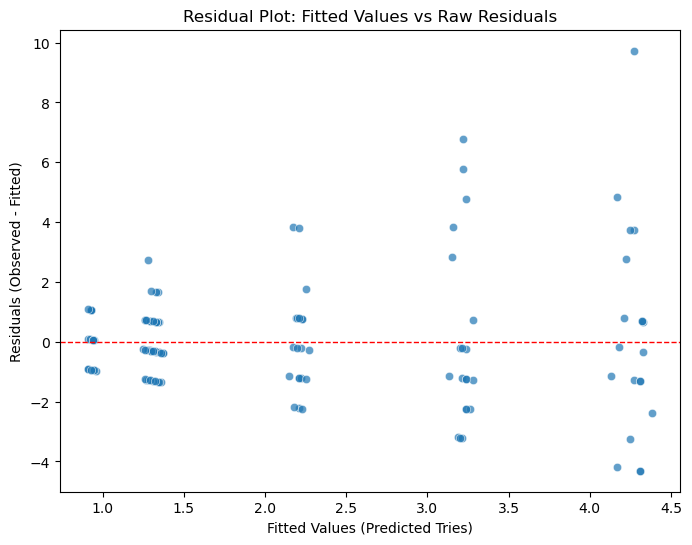

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

# Extract posterior mean of fitted values (expected counts)
fitted_values = df_expanded["predicted_tries_mean"].values

# Get observed counts
observed_values = df_expanded["team_tries"].values

# Compute residuals: Observed - Fitted
residuals = df_expanded["raw_residuals"].values

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=fitted_values, y=residuals, alpha=0.7)

# Add a horizontal line at zero (ideal residual pattern)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel("Fitted Values (Predicted Tries)")
plt.ylabel("Residuals (Observed - Fitted)")
plt.title("Residual Plot: Fitted Values vs Raw Residuals")

plt.show()


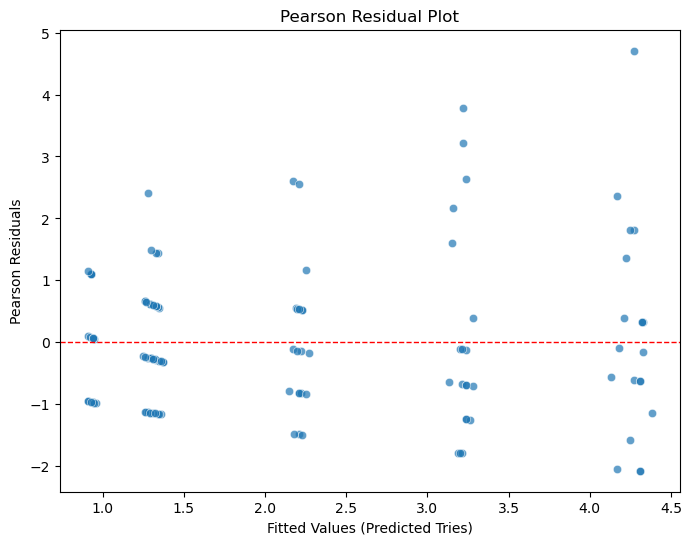

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

# Extract posterior mean of fitted values (expected counts)
fitted_values = df_expanded["predicted_tries_mean"].values

# Get observed counts
observed_values = df_expanded["team_tries"].values

# Compute residuals: Observed - Fitted
residuals = df_expanded["pearson_residuals"].values

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=fitted_values, y=residuals, alpha=0.7)

# Add a horizontal line at zero (ideal residual pattern)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel("Fitted Values (Predicted Tries)")
plt.ylabel("Pearson Residuals")
plt.title("Pearson Residual Plot")

plt.show()


In [34]:
# Mean is larger than Median due to Skew of NB distribution
df_expanded[['team','team_tries','predicted_tries_mean',
             'raw_residuals',"pearson_residuals","deviance_residuals"]]

,team,team_tries,predicted_tries_mean,raw_residuals,pearson_residuals,deviance_residuals
0,England,2,2.27,-0.27,-0.179205,-0.182946
1,France,2,3.21,-1.21,-0.675356,-0.726295
2,France,2,3.24,-1.24,-0.688889,-0.741819
3,England,3,2.23,0.77,0.515630,0.489555
4,England,0,2.21,-2.21,-1.486607,NaN
5,Ireland,0,4.31,-4.31,-2.076054,NaN
6,Ireland,7,4.22,2.78,1.353283,1.234929
7,England,1,2.21,-1.21,-0.813934,-0.913244
8,England,6,2.17,3.83,2.599973,2.131757
9,Italy,1,1.33,-0.33,-0.286146,-0.299403
